In [155]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#!pip install geojson
#!pip install geopandas
#!pip install geoplot
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import LineString

### Part 1

In [148]:
main_cdr_df = pd.read_csv("cdr.csv")
cdr_df = main_cdr_df.copy()
tower_df = pd.read_csv("towers.csv")

cdr_df.head()
#cdr_df.info()
#tower_df.head()

# 1.1) How many transactions are there?
n_calls = len(cdr_df['caller_id'])
print('Number of transactions: ', n_calls)

# 1.2) How many unique callers are there (how many subscribers place at least one call on the network)?
n_callers = cdr_df['caller_id'].nunique()
print('Number of unique callers: ', n_callers)

# 1.3: How many unique receivers are there (how many subscribers receive at least one call on the network)?
n_receivers = cdr_df['recipient_id'].nunique()
print('Number of unique receivers: ', n_receivers)

# 1.4: How many days does the data cover?
n_days = cdr_df['date'].nunique()
print('Number of days: ', n_days)

# 1.5 a: How many calls does the average subscriber place per day? 
caller_day_count = cdr_df.groupby(['caller_id','date']).size()
caller_day_count = caller_day_count.reset_index(name='call_count')
caller_avg_dailly_call = caller_day_count.groupby('caller_id')['call_count'].mean()
caller_avg_dailly_call = caller_avg_dailly_call.reset_index(name='avg_daily_call')

# 1.5 b:How many calls does the average subscriber receive per day?
receiver_day_count = cdr_df.groupby(['recipient_id','date']).size()
receiver_day_count = receiver_day_count.reset_index(name='call_count')
receiver_avg_dailly_call = receiver_day_count.groupby('recipient_id')['call_count'].mean()
receiver_avg_dailly_call = receiver_avg_dailly_call.reset_index(name='avg_daily_call')

print('Number of daily calls by average subsrciber: ', round(caller_avg_dailly_call['avg_daily_call'].mean()))
print('Actual non-integer value: ', caller_avg_dailly_call['avg_daily_call'].mean())
print('Number of daily calls received by average subscriber: ', round(receiver_avg_dailly_call['avg_daily_call'].mean()))
print('Actual non-integer value: ', receiver_avg_dailly_call['avg_daily_call'].mean())

# Add receiver average

#print('Average daily call per subscriber: ' )
#caller_day_count.head()
#caller_avg_dailly_call

Number of transactions:  13513
Number of unique callers:  145
Number of unique receivers:  146
Number of days:  91
Number of daily calls by average subsrciber:  2
Actual non-integer value:  1.6236718332565443
Number of daily calls received by average subscriber:  2
Actual non-integer value:  1.5891376758961882


### Part 2

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11516\1767926529.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  togo_gdf["area"] = togo_gdf.area
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11516\1767926529.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  togo_gdf["Centroid"] = togo_gdf.centroid


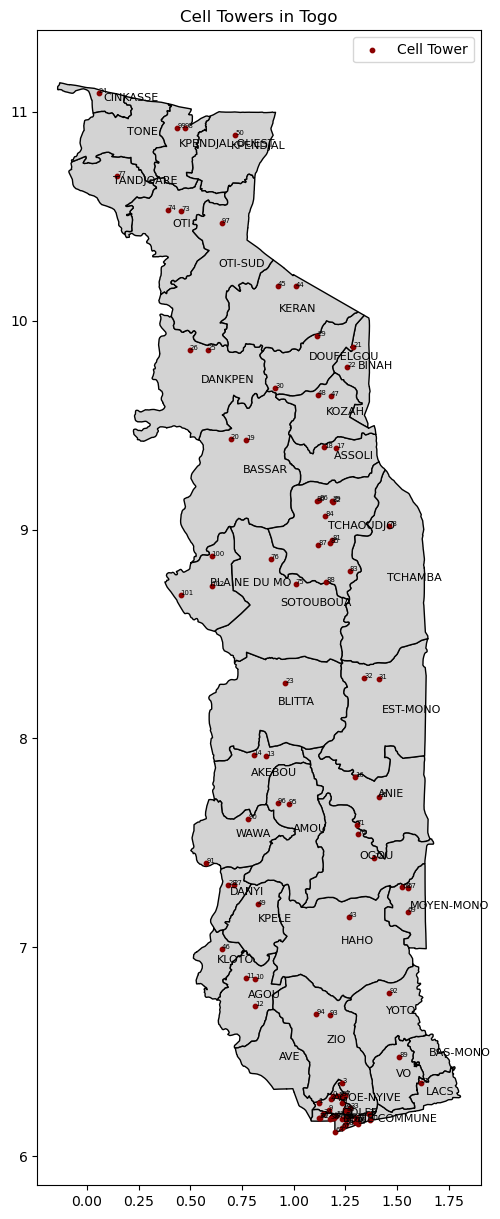

In [ ]:
# 2.1: Map of prefectures in Togo and the location of cell towers

# Ploting the map of Togo
togo_gdf = gpd.read_file('prefectures.geojson')
tower_gdf = gpd.GeoDataFrame(tower_df, geometry=gpd.points_from_xy(tower_df.longitude, tower_df.latitude), crs="EPSG:4326")

togo_gdf["area"] = togo_gdf.area
togo_gdf["Centroid"] = togo_gdf.centroid

ax = togo_gdf.plot(figsize=(15,15), color='lightgray', edgecolor='black')
tower_gdf.plot(color='darkred', ax=ax, label='Cell Tower', markersize=10)
plt.title("Cell Towers in Togo")
plt.legend()

# Indicating the names of the prefectures
for idx, row in togo_gdf.iterrows():
    plt.annotate(text=row["prefecture"], 
                 xy=[row["Centroid"].x, row["Centroid"].y], 
                 size=8)   
    

# Tower names on the map
for idx, row in tower_gdf.iterrows():
    plt.annotate(text=row["tower_id"][5:], 
                 xy=[row["longitude"], row["latitude"]], 
                 size=5)

In [159]:
# Counting the number of towers in each prefecture
tower_pref = cdr_df[['tower_id', 'prefecture']].drop_duplicates()
pref_no_tower = tower_pref.groupby('prefecture')['tower_id'].size().sort_values(ascending=False).reset_index(name='no_towers')

pref_no_tower.head()

,prefecture,no_towers
0,LOME COMMUNE,15
1,AGOE-NYIVE,10
2,GOLFE,10
3,TCHAOUDJO,10
4,PLAINE DU MO,3


### Part 3

Question 3.1: Describe at least three approaches you might take to infer which prefecture each subscriber lives in.
1) The prefecture hosting the tower through which the subscriber makes the most calls. For everay  
2) The prefecture hosting the tower through which the subsrriber makes the most weekend call.
3) The prefecture hosting the tower through which the subsrriber makes has the logest tower coeficient(a combinaiton of tower count and duration of call on tower). 


In [115]:
# Print recipiant_id not in caller_id
cdr_receiver_only = cdr_df[~cdr_df['recipient_id'].isin(cdr_df['caller_id'])]

print(cdr_receiver_only['recipient_id'].unique())
cdr_receiver_only.head()

['D8F040KM' '2LI3ERUW' 'UUQXQRFE' 'SQUN4FQ1']


,caller_id,recipient_id,date,time,duration,tower_id,prefecture,hour
64,UH87QXHH,D8F040KM,2020-01-01,12:17:27,29,tower90,WAWA,12
98,DVO6WS7K,D8F040KM,2020-01-01,16:27:48,100,tower22,BINAH,16
107,QNE5AS6C,2LI3ERUW,2020-01-01,17:05:20,121,tower100,PLAINE DU MO,17
163,FG4TKMTL,D8F040KM,2020-01-02,05:01:09,83,tower74,OTI,5
206,536AAL2Y,2LI3ERUW,2020-01-02,11:58:42,141,tower4,AGOE-NYIVE,11


Question 3.2: Choose one of your approaches from question 3.1, and implement it using the dataset provided. 
Produce a table with subscribers matched to the prefecture you estimate they live in, and include this table in your write-up.
tower per caller

In [160]:
# Getting
home_tower_drtn = cdr_df.groupby(['caller_id', 'tower_id'], as_index=False).agg({'duration': 'sum'})
home_tower = cdr_df.groupby(['caller_id','tower_id']).size().reset_index(name='tower_count')
home_tower_twr_cnt = home_tower.loc[home_tower.groupby('caller_id')['tower_count'].idxmax()]

# Calculating the tower coeficient
home_tower_df = home_tower.merge(home_tower_drtn, on=['caller_id', 'tower_id'], how='inner')
home_tower_df['tower_coef'] = home_tower_df['tower_count'] + home_tower_df['duration']/10000

#home_tower_main = home_tower_df.groupby(['caller_id'], as_index=False).agg({'tower_coef': 'max'})
home_tower_main = home_tower_df.loc[home_tower_df.groupby('caller_id')['tower_coef'].idxmax()]

# Comparing the number of duplicates when using the tower count and the tower coef
df1 = home_tower_df[home_tower_df.groupby('caller_id')['tower_count'].transform('max') == home_tower_df['tower_count']]
tower_dup = df1.duplicated(subset=['caller_id']).sum() # Counting duplicates when tower count is used 
df2 = home_tower_df[home_tower_df.groupby('caller_id')['tower_coef'].transform('max') == home_tower_df['tower_coef']]
coef_dup = df2.duplicated(subset=['caller_id']).sum() # Counting duplicates when tower coef is used

# Print number of duplicates by tower_count and tower_coef 
print('Number of duplicates by tower_count: ', tower_dup)
print('Number of duplicates by tower_coef: ', coef_dup)

# Creating a column called prefecture in tower_df and matching tower_id to prefecture from cdr_df
tower = cdr_df.drop_duplicates(subset=['tower_id'])
home_tower_main['prefecture'] = home_tower_main['tower_id'].map(tower.set_index('tower_id')['prefecture'])
home_tower_main.head()

# number of people called living in the same prefecture as the caller
cdr_df['caller_prefecture'] = cdr_df['caller_id'].map(home_tower_main.set_index('caller_id')['prefecture'])
cdr_df['receiver_prefecture'] = cdr_df['recipient_id'].map(home_tower_main.set_index('caller_id')['prefecture'])

# Percentage of callers and receivers living in the same prefecture
same_pref = cdr_df[cdr_df['caller_prefecture'] == cdr_df['receiver_prefecture']]
same_pref_count = len(same_pref)
total_calls = len(cdr_df)
same_pref_percentage = (same_pref_count/total_calls)*100

print('Percentage of calls made and received by people living in the same prefecture: ', same_pref_percentage)

# Prefecture receiveing the most calls 
most_calls = cdr_df.groupby('receiver_prefecture').size().reset_index(name='call_count')
most_calls = most_calls.loc[most_calls['call_count'].idxmax()]
print('Prefecture receiving the most calls: ', most_calls['receiver_prefecture'])

# Percentage of calls recieved in lome
lome_calls = cdr_df[cdr_df['receiver_prefecture'] == most_calls['receiver_prefecture']]
print('Percentage of calls received in Lome: ', (len(lome_calls)/total_calls)*100)

pref_by_twr_coef = home_tower_main[['caller_id', 'prefecture']].sort_values(by='caller_id')

pref_by_twr_coef.head()
subscriber_home = pref_by_twr_coef.copy()
#cdr_df.head()

subscriber_home.head(10)


Number of duplicates by tower_count:  40
Number of duplicates by tower_coef:  0
Percentage of calls made and received by people living in the same prefecture:  7.644490490638645
Prefecture receiving the most calls:  LOME COMMUNE
Percentage of calls received in Lome:  19.151927773255384


,caller_id,prefecture
15,06BA9LHR,OTI-SUD
18,0706DUPJ,AGOE-NYIVE
69,0HHVC11B,TCHAOUDJO
75,1DJTB0AG,AGOE-NYIVE
130,1S9T7ERF,KOZAH
146,23RJAXQ1,DANKPEN
171,2B4LACSW,LOME COMMUNE
213,3D70JPBF,LOME COMMUNE
243,3H7ROWGG,HAHO
300,3VZAX0RR,LOME COMMUNE


In [117]:
# Question 3.3: Does your algorithm infer a home prefecture for every subscriber in the dataset? Why or why not?

In [161]:
# Question 3.6: Pick a second approach from the three approaches you brainstormed in question 3.1, and implement it. 
# Produce a table with subscribers matched to the prefecture you estimate they live in, and include this table in your write-up.

# Using the maximum number of cell towers used by a subscriber
#home_tower_by_max = home_tower_df.loc[home_tower_df.groupby('caller_id')['tower_coef'].idxmax()]
home_tower_by_max = home_tower_twr_cnt
home_tower_by_max['pref_by_twer_cnt'] = home_tower_by_max['tower_id'].map(tower.set_index('tower_id')['prefecture'])

pref_by_max_twr = home_tower_by_max[['caller_id', 'pref_by_twer_cnt']]
pref_by_max_twr = pref_by_max_twr.sort_values(by='caller_id')

# Inner join of the two tables 
home_df = pref_by_twr_coef.merge(pref_by_max_twr, on=['caller_id'], how='inner')

# Counting number of prefectures that match and mismatch
home_df['match'] = home_df['prefecture'] == home_df['pref_by_twer_cnt']
match_count = home_df['match'].sum()
mismatch_count = len(home_df) - match_count

print('Number of prefectures that match: ', match_count)
print('Number of prefectures that mismatch: ', mismatch_count)

unmatched = home_df[home_df['match'] == False]
#unmatched.head()
home_df.head(10)



Number of prefectures that match:  135
Number of prefectures that mismatch:  10


,caller_id,prefecture,pref_by_twer_cnt,match
0,06BA9LHR,OTI-SUD,OTI-SUD,True
1,0706DUPJ,AGOE-NYIVE,AGOE-NYIVE,True
2,0HHVC11B,TCHAOUDJO,TCHAOUDJO,True
3,1DJTB0AG,AGOE-NYIVE,AGOE-NYIVE,True
4,1S9T7ERF,KOZAH,KOZAH,True
5,23RJAXQ1,DANKPEN,DANKPEN,True
6,2B4LACSW,LOME COMMUNE,LOME COMMUNE,True
7,3D70JPBF,LOME COMMUNE,LOME COMMUNE,True
8,3H7ROWGG,HAHO,HAHO,True
9,3VZAX0RR,LOME COMMUNE,LOME COMMUNE,True


### Part 4

In [119]:
home_tower_df.head()

,caller_id,tower_id,tower_count,duration,tower_coef
0,06BA9LHR,tower18,1,65,1.0065
1,06BA9LHR,tower20,1,42,1.0042
2,06BA9LHR,tower21,2,297,2.0297
3,06BA9LHR,tower24,1,87,1.0087
4,06BA9LHR,tower25,8,797,8.0797


Question 4.1: Using one of the two algorithms you implemented above, calculate which prefecture you believe each subscriber is living in each week. Choose five subscribers living in different parts of Togo (based on different home prefectures identified in the previous section), and provide a table showing which prefecture they are located in each week. Also produce a plot of the trajectories of these five subscribers on a map of Togo.

In [120]:
# number of weeks in the dataset
cdr_weekly_df = main_cdr_df.copy()
cdr_weekly_df['date'] = pd.to_datetime(cdr_weekly_df['date'])
cdr_weekly_df['week'] = cdr_weekly_df['date'].dt.isocalendar().week

weeks = range(1, 15)
weekly_dfs = []

for week in weeks:
    weekly_df = cdr_weekly_df[cdr_weekly_df['week'] == week].groupby(['caller_id', 'tower_id']).size().reset_index(name='tower_weekly_count')
    weekly_df['duration'] = cdr_weekly_df[cdr_weekly_df['week'] == week].groupby(['caller_id', 'tower_id'])['duration'].sum().values
    weekly_df['week'] = week
    weekly_df['coeficient'] = weekly_df['tower_weekly_count'] + weekly_df['duration']/10000
    weekly_dfs.append(weekly_df)

cdr_weekly_df1 = pd.concat(weekly_dfs, ignore_index=True)
cdr_weekly = cdr_weekly_df1.loc[cdr_weekly_df1.groupby(['caller_id','week'])['coeficient'].idxmax()]
cdr_weekly['prefecture'] = cdr_weekly['tower_id'].map(tower.set_index('tower_id')['prefecture'])

#df3 = cdr_weekly[cdr_weekly['caller_id'] == 'Q5BK8XEM']
#cdr_weekly.head(15)

weeks = range(1, max(cdr_weekly['week'])+1)
week_df = pd.DataFrame(columns=['caller_id', 'week1', 'week2', 'week3', 'week4', 'week5', 'week6', 'week7', 'week8', 'week9', 'week10', 'week11', 'week12', 'week13', 'week14'])
week_df['caller_id'] = cdr_weekly['caller_id'].unique()

for week in weeks:
    week_df['week'+str(week)] = week_df['caller_id'].map(cdr_weekly[cdr_weekly['week'] == week].set_index('caller_id')['prefecture'])

week_df.head(5)


,caller_id,week1,week2,week3,week4,week5,week6,week7,week8,week9,week10,week11,week12,week13,week14
0,06BA9LHR,KPENDJAL,OTI-SUD,OTI-SUD,OTI-SUD,OTI-SUD,OTI-SUD,OTI-SUD,OTI-SUD,OTI-SUD,KERAN,OTI-SUD,OTI-SUD,OTI,KERAN
1,0706DUPJ,LOME COMMUNE,AGOE-NYIVE,AGOE-NYIVE,LOME COMMUNE,AGOE-NYIVE,GOLFE,AGOE-NYIVE,AGOE-NYIVE,GOLFE,AGOE-NYIVE,LOME COMMUNE,LOME COMMUNE,LOME COMMUNE,AGOE-NYIVE
2,0HHVC11B,TCHAOUDJO,TCHAOUDJO,TCHAOUDJO,TCHAOUDJO,NaN,TCHAOUDJO,TCHAOUDJO,TCHAOUDJO,BASSAR,TCHAOUDJO,ASSOLI,TCHAOUDJO,ASSOLI,TCHAOUDJO
3,1DJTB0AG,GOLFE,LOME COMMUNE,AGOE-NYIVE,AGOE-NYIVE,AGOE-NYIVE,LOME COMMUNE,GOLFE,GOLFE,MOYEN-MONO,GOLFE,AGOE-NYIVE,GOLFE,GOLFE,AGOE-NYIVE
4,1S9T7ERF,BASSAR,ASSOLI,BINAH,KOZAH,TCHAOUDJO,KOZAH,KOZAH,BASSAR,BINAH,KOZAH,KOZAH,KOZAH,ASSOLI,KOZAH


In [ ]:
# Randomly select 5 subscibers 
sample_subs = subscriber_home.drop_duplicates(subset=['prefecture'])
sample = sample_subs.sample(n=5)

# Week_df for the sample subscribers
sample_week_df = week_df[week_df['caller_id'].isin(sample['caller_id'])]
sample.head()
sample_week_df.head()

,caller_id,week1,week2,week3,week4,week5,week6,week7,week8,week9,week10,week11,week12,week13,week14
2,0HHVC11B,TCHAOUDJO,TCHAOUDJO,TCHAOUDJO,TCHAOUDJO,NaN,TCHAOUDJO,TCHAOUDJO,TCHAOUDJO,BASSAR,TCHAOUDJO,ASSOLI,TCHAOUDJO,ASSOLI,TCHAOUDJO
11,4SEEL57M,AKEBOU,DANYI,WAWA,DANYI,DANYI,DANYI,DANYI,DANYI,DANYI,DANYI,DANYI,DANYI,DANYI,DANYI
20,6RUMEMGE,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA,BLITTA
35,AEOYEEI1,CINKASSE,CINKASSE,CINKASSE,CINKASSE,KPENDJAL,CINKASSE,CINKASSE,KPENDJAL-OUEST,KPENDJAL-OUEST,TANDJOARE,TANDJOARE,KPENDJAL-OUEST,OTI,NaN
73,ISF3IT7O,NaN,AKEBOU,AMOU,NaN,NaN,NaN,NaN,NaN,AKEBOU,AMOU,AMOU,WAWA,AMOU,WAWA


In [143]:
from shapely.geometry import LineString

prefecture_coords = {row["prefecture"]: row["Centroid"] for _, row in togo_gdf.iterrows()}
df = sample_week_df.copy()

caller_movements = df.iloc[0, 1:].dropna().tolist()  # Remove NaN values

# Convert prefecture names to their centroid coordinates
movement_points = [prefecture_coords[pref] for pref in caller_movements if pref in prefecture_coords]

# Create a LineString geometry for the movement path
movement_line = LineString(movement_points)

# Convert movement path into a GeoDataFrame
movement_gdf = gpd.GeoDataFrame(geometry=[movement_line], crs="EPSG:4326")


plt.show()

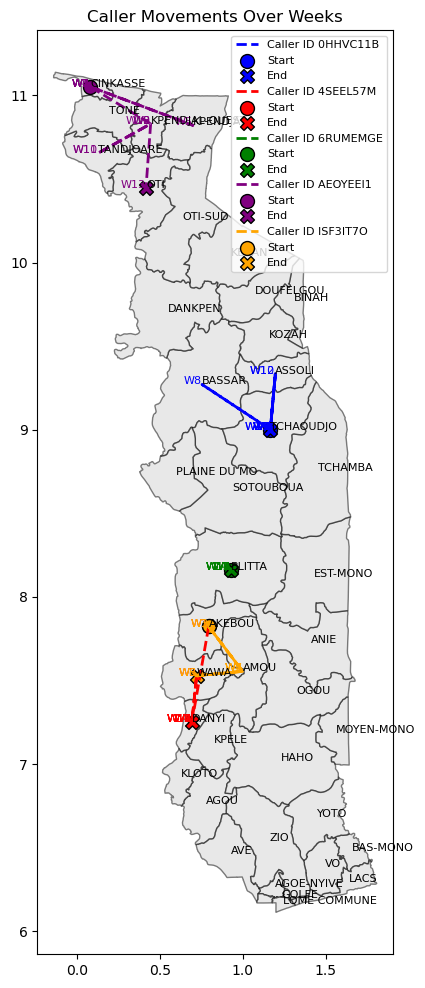

In [ ]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 12))
togo_gdf.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Define 5 distinct colors
colors = ["blue", "red", "green", "purple", "orange"]
caller_ids = df["caller_id"].unique()

# Looping through each caller ID
for idx, caller_id in enumerate(caller_ids):
    caller_data = df[df["caller_id"] == caller_id].iloc[:, 1:].dropna(axis=1)  # Get movement history
    
    # Extract prefecture movements
    movement_points = [prefecture_coords[pref] for pref in caller_data.values.flatten() if pref in prefecture_coords]
    
    # Plot if movement_points is not empty
    if movement_points:
        movement_line = LineString(movement_points)
        movement_gdf = gpd.GeoDataFrame(geometry=[movement_line], crs="EPSG:4326")
        
        # Ploting movement line
        movement_gdf.plot(ax=ax, color=colors[idx], linewidth=2, linestyle="--", label=f"Caller ID: {caller_id}")

        ax.scatter(movement_points[0].x, movement_points[0].y, color=colors[idx], s=100, edgecolors="black", label=f"Start")
        ax.scatter(movement_points[-1].x, movement_points[-1].y, color=colors[idx], s=100, marker="X", edgecolors="black", label=f"End")

        # Annotate weeks
        for i, point in enumerate(movement_points):
            ax.annotate(f"W{i+1}", (point.x, point.y), fontsize=8, ha="right", color=colors[idx])

# Indicating the names of the prefectures
for idx, row in togo_gdf.iterrows():
    plt.annotate(text=row["prefecture"], 
                 xy=[row["Centroid"].x, row["Centroid"].y], 
                 size=8)  
plt.title("Caller Movements Over Weeks")
plt.legend(fontsize=8)
plt.show()

Question 4.2: Are you able to infer the location of every subscriber in the dataset every week? If not, how many subscribers are missing “homes” on average each week?

In [167]:
# Average number of subscribers missing home weekly
week_df['nan_count'] = week_df.isnull().sum(axis=1)
week_df['avg_nan'] = (week_df['nan_count'].sum())/14

print('Average number of subscribers missing home weekly: ', week_df['avg_nan'].mean())
print('Value in integer: ', round(week_df['avg_nan'].mean()))

Average number of subscribers missing home weekly:  11.14285714285714
Value in integer:  11


Test Code 

In [169]:
# weeks = range(1, max(cdr_weekly['week'])+1)
# week_df = pd.DataFrame(columns=['caller_id', 'week1', 'week2', 'week3', 'week4', 'week5', 'week6', 'week7', 'week8', 'week9', 'week10', 'week11', 'week12', 'week13', 'week14'])
# week_df['caller_id'] = cdr_weekly['caller_id'].unique()

# for week in weeks:
#     week_df['week'+str(week)] = week_df['caller_id'].map(cdr_weekly[cdr_weekly['week'] == week].set_index('caller_id')['prefecture'])

# week_df.head(5)

In [168]:
# cdr_weekly_df1 = pd.concat(weekly_dfs, ignore_index=True)

# cdr_weekly_df1.sample(5)

# df3 = cdr_weekly_df1[cdr_weekly_df1['caller_id'] == 'Q5BK8XEM']

# # Extract weekly maximum coeficient using groupby
# cdr_weekly = df3.loc[df3.groupby('week')['coeficient'].idxmax()]

# cdr_weekly.head(15)
# week_df.head(20)